In [1]:
library(tidyverse)

library(patchwork)
library(ggplot2)

source("../../utils/plots_eda.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: viridisLite



# Results processing

In [ ]:
seed_list <- c(6, 11, 20, 42, 150)

for (mode in c("before", "after")) {
  for (seed in seed_list) {
    # Define the path and list all zip files
    path_to_fed <- paste0("after/kmeans_res/", mode, "/multiple_runs/", seed, "/")
    zip_files <- list.files(path = path_to_fed, pattern = "\\.zip$", full.names = TRUE)

    # Required file paths inside the zip archives
    required_files <- c(
      "kmeans/K_2/clustering.csv", "kmeans/K_6/clustering.csv",
      "design.tsv"
    )

    for (i in seq_along(zip_files)) {
      zipfile <- zip_files[i]
      zip_contents <- unzip(zipfile, list = TRUE)$Name

      # Process each required file within the zip archive
      for (req in required_files) {
        if (!req %in% zip_contents) {
          warning(sprintf("File '%s' not found in zip: %s", req, zipfile))
          next
        }

        # Extract the specific file to the destination folder
        unzip(zipfile, files = req, exdir = path_to_fed)

        # Determine the destination filename based on the required file
        # Extract the specific part ("2" or "5") from the path using a simple regex:
        match <- regexpr("K_([0-9]+)", req)
        extracted_num <- if (match[1] != -1) substring(req, match[1] + 2, match[1] + attr(match, "match.length") - 1) else "unknown"
        new_csv_name <- file.path(path_to_fed, sprintf("%d_%s_clustering.csv", i, extracted_num))

        # Determine the path to the extracted file (it might be in a subdirectory)
        extracted_csv_path <- file.path(path_to_fed, req)
        if (!file.exists(extracted_csv_path)) {
          # Search recursively if not found in the expected location
          extracted_files <- list.files(path_to_fed, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)
          candidate <- extracted_files[basename(extracted_files) == basename(req)]
          if (length(candidate) > 0) {
            extracted_csv_path <- candidate[1]
          } else {
            warning(sprintf("Extracted CSV file not found for '%s' in zip: %s", req, zipfile))
            next
          }
        }

        # Rename (or move) the extracted file to the new filename
        if (!file.rename(from = extracted_csv_path, to = new_csv_name)) {
          warning(sprintf("Failed to rename file: %s to %s", extracted_csv_path, new_csv_name))
        }
      }
    }
  }
}


# Read clustering results

In [19]:
seed_list <- c(6, 11, 20, 42, 150)
design_all <- NULL

for (seed in seed_list) {
  for (mode in c("before", "after")) {
    design_result <- NULL
    path_to_fed <- paste0("after/kmeans_res/", mode, "/multiple_runs/", seed)

    for (i in 1:6) {
      # Read design
      design <- read_delim(
        file = file.path(path_to_fed, paste0(i, "_unknown_clustering.csv")),
        col_names = TRUE,
        delim = "\t",
        show_col_types = FALSE
      )

      # Read clustering result and rename
      clustering_results <- read_delim(
        file = file.path(path_to_fed, paste0(i, "_2_clustering.csv")),
        col_names = TRUE,
        delim = ";",
        show_col_types = FALSE
      ) %>%
        rename(cluster0 = `0`)

      # Append cluster column with clear naming
      suffix <- paste0("Fed_K2_", mode, "_", seed)
      design[[suffix]] <- clustering_results$cluster0

      # Accumulate
      design_result <- bind_rows(design_result, design)
    }

    # Merge into the global result
    if (is.null(design_all)) {
      design_all <- design_result
    } else {
      design_all <- full_join(
        design_all, design_result,
        by = c("sample_id", "Status", "batch")
      )
    }
  }
}


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
•

In [21]:
# write design_all to file
write_delim(
    design_all,
    "after/design_all.tsv",
    delim = "\t",
    col_names = TRUE
)

# New columns added

In [99]:
design_all <- read_delim(
    "after/design_all_updated.tsv",
    col_names = TRUE,
    delim = "\t",
    # supress warnings
    show_col_types = FALSE
)
colnames(design_all)

[1] "sample_id"           "Status"              "batch"              
 [4] "Fed_K2_before_6"     "Fed_K2_after_6"      "Fed_K2_before_11"   
 [7] "Fed_K2_after_11"     "Fed_K2_before_20"    "Fed_K2_after_20"    
[10] "Fed_K2_before_42"    "Fed_K2_after_42"     "Fed_K2_before_150"  
[13] "Fed_K2_after_150"    "Centr_2K_before_6"   "Centr_2K_before_11" 
[16] "Centr_2K_before_20"  "Centr_2K_before_42"  "Centr_2K_before_150"
[19] "Centr_2K_after_6"    "Centr_2K_after_11"   "Centr_2K_after_20"  
[22] "Centr_2K_after_42"   "Centr_2K_after_150"

In [100]:
mcc <- function(truth, pred) {
  # ensure same factor levels
  truth <- factor(truth); pred <- factor(pred, levels=levels(truth))
  tp <- sum(truth == levels(truth)[2] & pred == levels(truth)[2])
  tn <- sum(truth == levels(truth)[1] & pred == levels(truth)[1])
  fp <- sum(truth == levels(truth)[1] & pred == levels(truth)[2])
  fn <- sum(truth == levels(truth)[2] & pred == levels(truth)[1])
  num <- tp * tn - fp * fn
  den <- sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
  if (den == 0) return(NA_real_)
  num/den
}

mcc_df <- design_all %>%
  select(Status, starts_with(c("Fed", "Centr"))) %>%
  select(-Status) %>%              # drop truth column
  map_dbl(~ mcc(design_all$Status, .x)) %>%
  enframe(name = "feature", value = "MCC")

neg_cols <- mcc_df %>%
  filter(MCC < 0) %>%
  pull(feature)


design_all <- design_all %>%
  mutate(
    across(
      .cols = all_of(neg_cols),
      .fns  = ~ factor(
        ifelse(as.character(.x) == "0", "1", "0"),
        levels = c("0", "1")
      )
    )
  )

mcc_df_updated <- design_all %>%
  select(Status, all_of(neg_cols)) %>%
  select(-Status) %>%
  map_dbl(~ mcc(design_all$Status, .x)) %>%
  enframe(name = "feature", value = "MCC")

print(mcc_df_updated)

# A tibble: 0 × 2
# ℹ 2 variables: feature <chr>, MCC <dbl>


In [101]:
# write design_all to file
write_delim(
    design_all,
    "after/design_all_updated.tsv",
    delim = "\t",
    col_names = TRUE
)

In [79]:
design_all <- design_all %>%
  mutate(
    # 1. custom-factor Status
    Status = factor(Status,
                    levels = c(0, 1),
                    labels = c("Control", "Tumor")),
    # 2. factor everything else
    across(.cols = -Status,    # “all columns except Status”
           .fns  = as.factor)
  )

# plots based on the results

In [80]:
expr_before <- read_delim(
    "before/all_expr_for_correction.tsv", 
    col_names = TRUE,
    delim = "\t",
    # supress warnings
    show_col_types = FALSE
) %>%  column_to_rownames("gene_id")
# expr_before <- t(expr_before) %>% as.data.frame()
expr_before <- expr_before[,design_all$sample_id]
print(dim(expr_before))

[1] 13237   309


In [81]:
expr_after <- read_delim(
    "after/all_corrected_R_expr.tsv", 
    col_names = TRUE,
    delim = "\t",
    # supress warnings
    show_col_types = FALSE
) %>%  column_to_rownames("gene_id")
expr_after <- expr_after[,design_all$sample_id]
print(dim(expr_after))

[1] 13237   309


In [82]:
# Define a list with all plot parameter sets
plot_params <- list(
  list(
    df        = expr_before,
    title    = "Uncorrected data, known labels",
    col_col  = "Status",
    shape_col = "batch"
  ),
  list(
    df        = expr_before,
    title    = "Uncorrected data, central kmeans (k=2)",
    col_col  = "Centr_2K_before_20",
    shape_col = "batch"
  ),
  list(
    df        = expr_before,
    title    = "Uncorrected data, fed clustering (k=2)",
    col_col  = "Fed_K2_before_20",
    shape_col = "batch"
  ),
  list(
    df        = expr_after,
    title    = "Central corrected data, known labels",
    col_col  = "Status",
    shape_col = "batch"
  ),
  list(
    df        = expr_after,
    title    = "Central corrected data, central kmeans (k=2)",
    col_col  = "Centr_2K_after_20",
    shape_col = "batch"
  ),
  list(
    df        = expr_after,
    title     = "Fed corrected data, fed clustering (k=2)",
    col_col   = "Fed_K2_after_20",
    shape_col = "batch"
  )
)

# Create an empty list to store the plots
plots_list <- list()

# Loop over each set of parameters and generate a plot
for(i in seq_along(plot_params)) {
  params <- plot_params[[i]]
  plots_list[[i]] <- pca_plot(
    df = params$df,
    batch_info = design_all,
    title = params$title,
    quantitative_col_name = "sample_id",
    col_col = params$col_col,
    shape_col = params$shape_col
  )
}

# Optionally, name the list elements for clarity:
names(plots_list) <- sapply(plot_params, function(x) x$title)


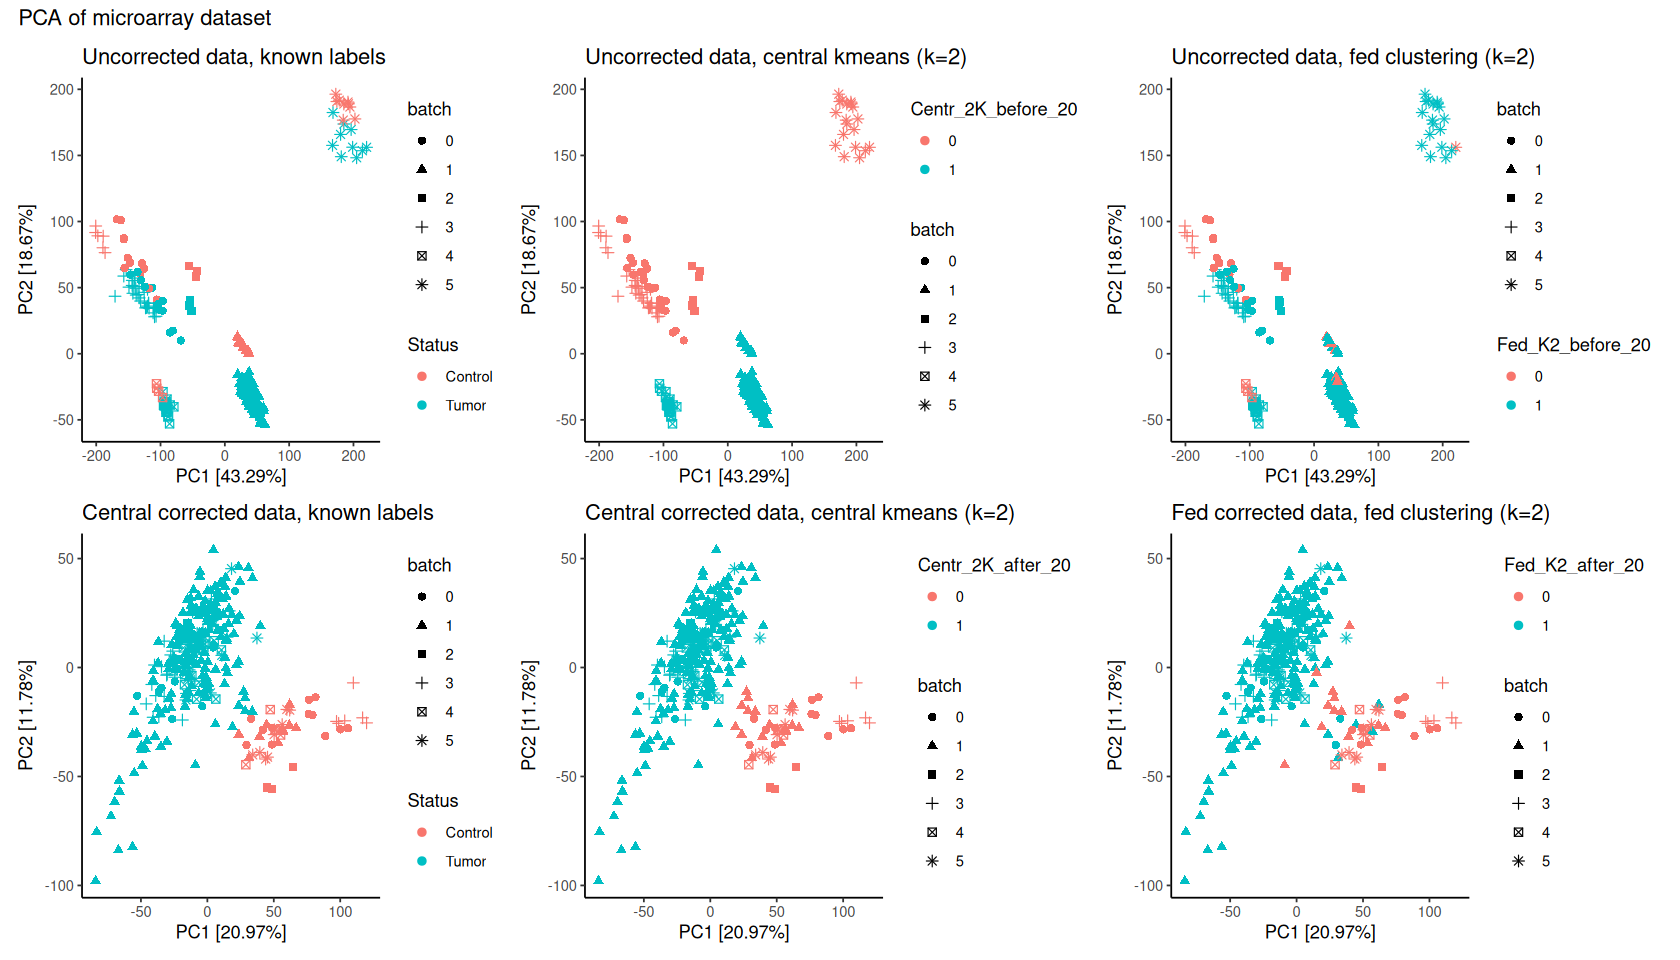

In [83]:
options(repr.plot.width=14, repr.plot.height=8)

combined_patchwork <- (
  plots_list[[1]] +
  plots_list[[2]] +
  plots_list[[3]] +
  plots_list[[4]] +
  plots_list[[5]] +
  plots_list[[6]] 
) + plot_layout(ncol = 3) + plot_annotation(title = "PCA of microarray dataset")
# Display the combined plot
print(combined_patchwork)

# Scores

In [102]:
f1_score_single <- function(df, pred_col, true_col, positive = 1) {
  # Create confusion matrix
  cm <- table(Predicted = df[[pred_col]], Actual = df[[true_col]])
  
  # Ensure the positive class exists in the confusion matrix
  if(!(positive %in% rownames(cm)) || !(positive %in% colnames(cm))) {
    stop("The specified positive class is not present in the predictions or actual labels.")
  }
  
  # Calculate True Positives, False Positives, and False Negatives
  TP <- cm[as.character(positive), as.character(positive)]
  FP <- sum(cm[as.character(positive), ]) - TP
  FN <- sum(cm[, as.character(positive)]) - TP
  TN <- sum(cm) - (TP + FP + FN)
  
  # Compute precision, recall and F1 score
  precision <- if ((TP + FP) == 0) NA else TP / (TP + FP)
  recall <- if ((TP + FN) == 0) NA else TP / (TP + FN)
  f1 <- if (is.na(precision) || is.na(recall) || (precision + recall) == 0) NA else 2 * precision * recall / (precision + recall)
  
  # Specificity calculation: TN/(TN+FP)
  specificity <- if ((TN + FP) == 0) NA else TN / (TN + FP)
  
  # Balanced Accuracy: (Sensitivity + Specificity)/2
  balanced_accuracy <- if (is.na(recall) || is.na(specificity)) NA else (recall + specificity) / 2
  
  # Matthews Correlation Coefficient (MCC)
  denominator <- sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
  mcc <- if (denominator == 0) NA else (TP * TN - FP * FN) / denominator
  
  # Return a named vector with all the computed metrics
  return(c(f1_score = f1,
           precision = precision,
           recall = recall,
           specificity = specificity,
           balanced_accuracy = balanced_accuracy,
           mcc = mcc))
}

In [103]:
design_all <- read_delim(
    "after/design_all_updated.tsv",
    col_names = TRUE,
    delim = "\t",
    # supress warnings
    show_col_types = FALSE
)

In [104]:
mcc_split <- mcc_df %>%
  mutate(
    # pull off the final underscore+digits as a seed
    seed         = str_extract(feature, "\\d+$"),
    # remove that suffix to get the “base” feature
    feature_base = str_remove(feature, "_\\d+$")
  )

mcc_summary <- mcc_split %>%
  group_by(feature_base) %>%
  summarise(
    mean_MCC   = mean(MCC, na.rm = TRUE),
    sd_MCC     = sd(MCC, na.rm = TRUE)
  ) %>%
  ungroup()


mcc_summary <- mcc_split %>%
  filter(str_detect(feature_base, "^(Fed|Centr)")) %>%
  group_by(feature_base) %>%
  summarise(
    mean_MCC   = mean(MCC, na.rm = TRUE),
    sd_MCC     = sd(MCC, na.rm = TRUE)
  ) %>%
  ungroup()

mcc_summary

feature_base,mean_MCC,sd_MCC
<chr>,<dbl>,<dbl>
Centr_2K_after,0.9079982,0.004747568
Centr_2K_before,0.3626379,0.000000000
Fed_K2_after,0.7922047,0.000000000
Fed_K2_before,0.6602596,0.000000000


In [106]:
# 1A. list of all clustering columns
cols <- design_all %>% 
  select(starts_with(c("Fed","Centr"))) %>% 
  names()

# 1B. compute metrics for each column, returning a tibble with one row per feature
metrics_df <- map_dfr(cols, function(colname) {
  # call your function, returns a named vector of length 6
  vals <- f1_score_single(design_all, pred_col = colname, true_col = "Status", positive = 0)
  
  # pack into a tibble row, add feature name
  as_tibble_row(vals) %>%
    mutate(feature = colname)
})

metrics_split <- metrics_df %>%
  mutate(
    seed         = str_extract(feature, "\\d+$"),
    feature_base = str_remove(feature, "_\\d+$")
  )

summary_df <- metrics_split %>%
  pivot_longer(
    cols      = f1_score:mcc,    # all metric columns
    names_to  = "metric",
    values_to = "value"
  ) %>%
  group_by(feature_base, metric) %>%
  summarise(
    mean = mean(value, na.rm = TRUE),
    sd = sd(value, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(feature_base, metric)


summary_wide <- summary_df %>%
  pivot_wider(
    names_from  = metric,
    values_from = c(mean, sd),
    names_sep   = "_"
  ) %>%
  # sort by feature_base column in the next order : Centr_2K_before, Fed_K2_before, Centr_2K_after, Fed_K2_after
  arrange(
    factor(feature_base, levels = c("Centr_2K_before", "Fed_K2_before", "Centr_2K_after", "Fed_K2_after"))
  )

summary_wide


feature_base,mean_balanced_accuracy,mean_f1_score,mean_mcc,mean_precision,mean_recall,mean_specificity,sd_balanced_accuracy,sd_f1_score,sd_mcc,sd_precision,sd_recall,sd_specificity
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Centr_2K_before,0.7333619,0.4580153,0.3626379,0.3448276,0.6818182,0.7849057,0.0000000000,0.000000000,0.000000000,0.000000000,0,0.000000000
Fed_K2_before,0.8030875,0.7000000,0.6602596,0.7777778,0.6363636,0.9698113,0.0000000000,0.000000000,0.000000000,0.000000000,0,0.000000000
Centr_2K_after,0.9852830,0.9185965,0.9079982,0.8494721,1.0000000,0.9705660,0.0008437992,0.004315219,0.004747568,0.007419833,0,0.001687598
Fed_K2_after,0.9034734,0.8222222,0.7922047,0.8043478,0.8409091,0.9660377,0.0000000000,0.000000000,0.000000000,0.000000000,0,0.000000000


In [93]:
# save to file
write_delim(
    summary_wide,
    "after/summary_wide.tsv",
    delim = "\t",
    col_names = TRUE
)